In [1]:
import pandas as pd

In [2]:
# Load the dataset to understand its structure and first few entries
file_path = '../data/dataset.csv'
data = pd.read_csv(file_path)

# Display the first few rows of the dataframe
data.head()

,verifiedby,country,class,title,published_date,country1,country2,country3,country4,article_source,ref_source,source_title,content_text,category,lang
0,La Silla Vacía,Colombia,FALSE,The coronavirus is an amplified bacteria rela...,2020/06/17,Colombia,NaN,NaN,NaN,https://lasillavacia.com/detector-video-falso-...,poynter,Detector a video falso que dice que el Covid e...,La Silla Vacía usa Cookies para mejorar la exp...,NaN,es
1,Newtral.es,Spain,FALSE,A law allows people to go for a run during th...,2020/04/09,Spain,NaN,NaN,NaN,https://www.newtral.es/la-broma-de-que-a-los-r...,poynter,La broma de que a los “runners” se les permite...,En los últimos días nos ha llegado una consult...,NaN,es
2,FactCrescendo,India,False,Chinese converting to Islam after realizing t...,2020/02/20,India,NaN,NaN,NaN,https://english.factcrescendo.com/2020/02/20/c...,poynter,Are Chinese people converting to Islam in fear...,"The fact behind every news!, Ever since the Wo...",NaN,en
3,France 24 Observers,France,False,Bat market and bat meat are being sold in Wuhan.,2020/01/27,France,NaN,NaN,NaN,https://observers.france24.com/fr/20200130-int...,poynter,"La soupe à la chauve-souris, un plat prisé en ...","عربي, English, Français, Contribuer, فارسی, عر...",NaN,fr
4,Agência Lupa,Brazil,False,You can self-diagnose COVID-19 by holding you...,2020/03/16,Brazil,NaN,NaN,NaN,https://piaui.folha.uol.com.br/lupa/2020/03/16...,poynter,#Verificamos: É falso que quem consegue prende...,", “O novo CORONA VÍRUS pode não mostrar sinais...",NaN,pt


In [3]:
# Assessing missing values across the dataset
missing_values = data.isnull().sum()

# Checking the unique values in the 'class' column to ensure consistency
class_values = data['class'].unique()

missing_values, class_values

(verifiedby           0
 country            172
 class                2
 title                0
 published_date       0
 country1           172
 country2          6343
 country3          6801
 country4          6873
 article_source       7
 ref_source           0
 source_title       454
 content_text       775
 category          6730
 lang               342
 dtype: int64,
 array(['FALSE', 'False', 'MISLEADING', 'Mostly True', 'No Evidence',
        'Misleading', 'partly false', 'Mostly false', 'Partly false',
        'PARTLY FALSE', 'Explanatory', 'No evidence', 'Mostly False',
        'misleading', 'Labeled Satire', 'Partly False', 'Misleading/False',
        'no evidence', 'True', 'MOSTLY FALSE', 'Unproven', 'false', 'Fake',
        'Half True', 'PARTLY TRUE', 'Not true', 'Scam',
        "(Org. doesn't apply rating)", 'Partially false', 'MOSTLY TRUE',
        'Partly true', 'mislEADING', 'half true', 'false and misleading',
        'mostly false', nan, 'HALF TRUE', 'Two Pinocchios', 

The dataset has various missing values across different columns. Most notably:

- country, country1: There are 172 missing values in each, which might be the same entries.
- country2, country3, country4: A large number of missing values, indicating that many news articles are not associated with multiple countries.
- article_source: 7 missing values, which is crucial because it's the source link to the article.
- source_title: 454 missing values, indicating missing titles in the original language.
- content_text: 775 missing entries, which might affect the analysis if the text content is needed for model training.
- category: A significant number of missing values (6730), suggesting that many articles are not categorized.
- lang: 342 missing values indicating the language is unknown for some entries.

For the 'class' column, which is our target variable, there are inconsistencies and missing values that need to be addressed. The column contains a variety of labels that are not strictly 'True' or 'False', such as:

- Different capitalizations of 'False' (e.g., 'FALSE', 'False', 'false') and similar issues with 'True'.
- Categories like 'Misleading', 'Mostly True', 'No Evidence', etc., which do not conform to a binary classification without further interpretation.
- Some labels are clearly irrelevant or not useful for binary classification, such as 'Explanatory', 'Labeled Satire', or 'Collections'.

Let's start by cleaning the 'class' column to have a uniform binary target. For the purpose of this binary classification task, we could consider labels that signify any degree of falsehood, such as 'False', 'Misleading', 'Mostly false', etc., as 'False', and labels that signify truth, such as 'True', 'Mostly True', etc., as 'True'. Ambiguous labels like 'No Evidence' or 'Unproven' could be carefully analyzed to decide on their inclusion as 'False' or removal from the dataset.

In [4]:
# Impute 'No Country' where values are missing for the country columns
country_columns = ['country','country1', 'country2', 'country3', 'country4']
for column in country_columns:
    data[column].fillna('No Country', inplace=True)

# Check the result of the imputation
data[country_columns].head()

,country,country1,country2,country3,country4
0,Colombia,Colombia,No Country,No Country,No Country
1,Spain,Spain,No Country,No Country,No Country
2,India,India,No Country,No Country,No Country
3,France,France,No Country,No Country,No Country
4,Brazil,Brazil,No Country,No Country,No Country


In [5]:
# For simplicity, we will map various forms of 'True' and 'False' to a binary system.
# We will treat 'Mostly True', 'True' and similar as True and 'False', 'Mostly False', 'Misleading' and similar as False.
# Ambiguous labels like 'No Evidence', 'Unproven' will be excluded.

# First, we define the mappings for 'True' and 'False'
true_labels = ['True', 'Mostly True', 'true', 'mostly true', 'True but', 'Mostly true', 'Correct', 
               'Partially correct', 'HALF TRUE', 'Half True', 'PARTLY TRUE', 'Mostly TRUE', 'MOSTLY TRUE']

false_labels = ['False', 'FALSE', 'false', 'Mostly False', 'MOSTLY FALSE', 'Mostly false', 'MISLEADING', 
                'Misleading', 'misleading', 'mislEADING', 'MiSLEADING', 'Misleading/False', 'False and misleading', 
                'FALSE AND MISLEADING', 'Partly false', 'PARTLY FALSE', 'Partly False', 'partly false', 
                'Partially false', 'Partially False', 'PARTIALLY FALSE', 'Fake', 'fake', 'FAKE', 'Scam', 
                'PANTS ON FIRE', 'Misinformation / Conspiracy theory', 'Two Pinocchios']

# Now, we'll create a function to map the class to binary
def map_class(label):
    if label in true_labels:
        return 'True'
    elif label in false_labels:
        return 'False'
    else:
        return 'Ambiguous'

# Apply the mapping function to the class column
data['binary_class'] = data['class'].apply(map_class)

# Remove ambiguous entries
data_binary = data[data['binary_class'] != 'Ambiguous']

# Count the distribution of the binary classes
binary_class_distribution = data_binary['binary_class'].value_counts()

binary_class_distribution


binary_class
False    6670
True       65
Name: count, dtype: int64

The dataset has been mapped to binary classes with the following distribution:

- False: 6670 entries
- True: 65 entries

It's evident that the dataset is highly imbalanced, with a vast majority of entries classified as 'False'. This imbalance will need to be addressed during the model training process to prevent the model from being biased towards predicting 'False' for nearly all inputs.

In [6]:
# Assessing missing values across the dataset
missing_values = data.isnull().sum()

# Checking the unique values in the 'class' column to ensure consistency
class_values = data['class'].unique()

missing_values, class_values

(verifiedby           0
 country              0
 class                2
 title                0
 published_date       0
 country1             0
 country2             0
 country3             0
 country4             0
 article_source       7
 ref_source           0
 source_title       454
 content_text       775
 category          6730
 lang               342
 binary_class         0
 dtype: int64,
 array(['FALSE', 'False', 'MISLEADING', 'Mostly True', 'No Evidence',
        'Misleading', 'partly false', 'Mostly false', 'Partly false',
        'PARTLY FALSE', 'Explanatory', 'No evidence', 'Mostly False',
        'misleading', 'Labeled Satire', 'Partly False', 'Misleading/False',
        'no evidence', 'True', 'MOSTLY FALSE', 'Unproven', 'false', 'Fake',
        'Half True', 'PARTLY TRUE', 'Not true', 'Scam',
        "(Org. doesn't apply rating)", 'Partially false', 'MOSTLY TRUE',
        'Partly true', 'mislEADING', 'half true', 'false and misleading',
        'mostly false', nan, 'HALF T

In [7]:
# We will proceed with handling missing values. The strategy will be:
# 1. Drop columns with a high percentage of missing values as they may not provide valuable information.
# 2. For columns with a lower percentage of missing values, we might impute or drop the missing entries depending on the context.

# Let's define a threshold for dropping columns. If a column has more than 50% missing values, we'll consider dropping it.
threshold = 0.5 * len(data_binary)

# Dropping columns with missing values exceeding the threshold
columns_to_drop = missing_values[missing_values > threshold].index.tolist()

# Drop the identified columns
data_cleaned = data_binary.drop(columns=columns_to_drop)

# Now, let's handle the remaining columns with missing values by dropping rows with any missing values.
# This is a strict approach, typically we might want to impute these, but without domain knowledge, it's safer to drop them.
data_cleaned = data_cleaned.dropna()

# Let's check the shape of the cleaned data and the remaining missing values
cleaned_shape = data_cleaned.shape
remaining_missing_values = data_cleaned.isnull().sum()

cleaned_shape, remaining_missing_values


((5834, 15),
 verifiedby        0
 country           0
 class             0
 title             0
 published_date    0
 country1          0
 country2          0
 country3          0
 country4          0
 article_source    0
 ref_source        0
 source_title      0
 content_text      0
 lang              0
 binary_class      0
 dtype: int64)

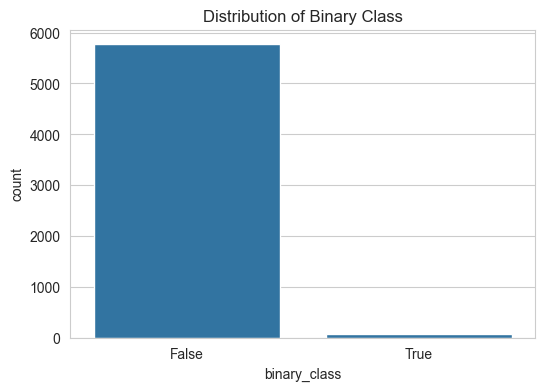

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Detailed Exploratory Data Analysis (EDA)

# Setting up the aesthetic style of the plots
sns.set_style("whitegrid")

# Summary statistics for numerical features
numerical_summary = data_cleaned.describe()

# Distribution of the binary class
plt.figure(figsize=(6, 4))
sns.countplot(data=data_cleaned, x='binary_class')
plt.title('Distribution of Binary Class')
plt.show()


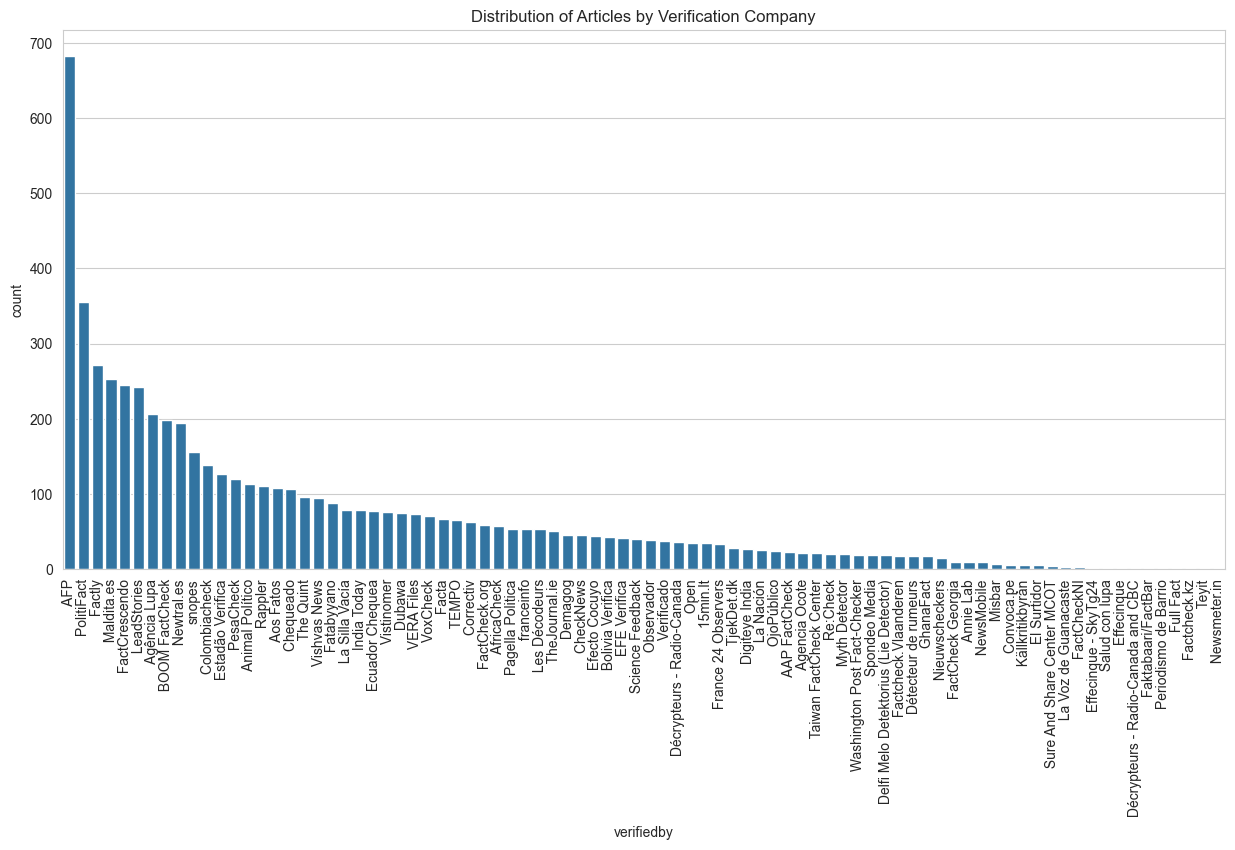

In [9]:
# To further understand the dataset and find insights for feature engineering, let's dive deeper into EDA.

# We will look into the following:
# 1. Distribution of articles by verification company (verifiedby)
# 2. Distribution of articles by country (country and country1)
# 3. Distribution of articles by language (lang)
# 4. Temporal distribution of articles (published_date)

# First, let's convert 'published_date' to datetime for temporal analysis
data_cleaned['published_date'] = pd.to_datetime(data_cleaned['published_date'], errors='coerce')
data_cleaned['year'] = data_cleaned['published_date'].dt.year
data_cleaned['month'] = data_cleaned['published_date'].dt.month

# Distribution of articles by verification company
plt.figure(figsize=(15, 7))
sns.countplot(data=data_cleaned, x='verifiedby', order=data_cleaned['verifiedby'].value_counts().index)
plt.xticks(rotation=90)
plt.title('Distribution of Articles by Verification Company')
plt.show()


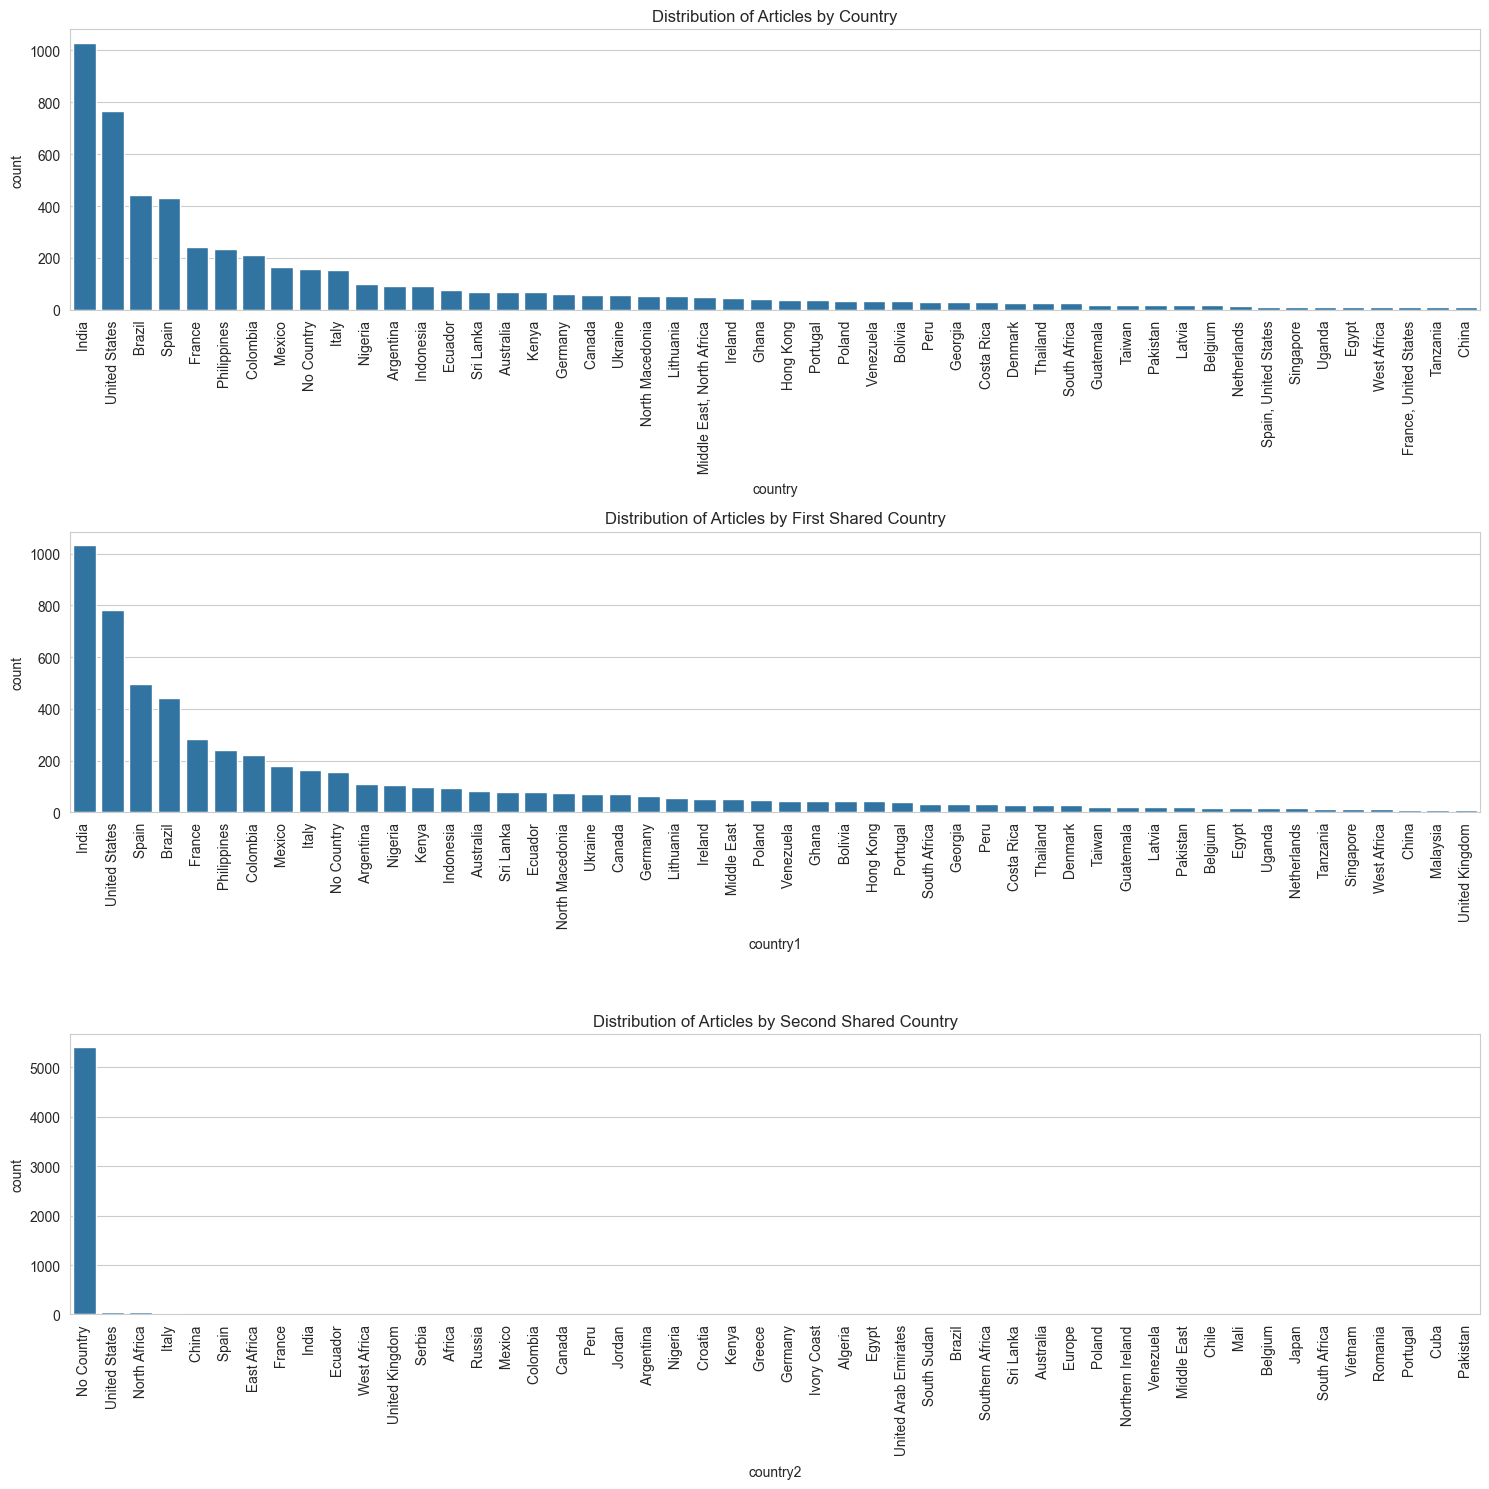

In [10]:
# Distribution of articles by country
fig, ax = plt.subplots(3, 1, figsize=(15, 15))
sns.countplot(data=data_cleaned, x='country', order=data_cleaned['country'].value_counts()[0:50].index, ax=ax[0])
ax[0].set_title('Distribution of Articles by Country')
ax[0].tick_params(axis='x', rotation=90)
sns.countplot(data=data_cleaned, x='country1', order=data_cleaned['country1'].value_counts()[0:50].index, ax=ax[1])
ax[1].set_title('Distribution of Articles by First Shared Country')
ax[1].tick_params(axis='x', rotation=90)
sns.countplot(data=data_cleaned, x='country2', order=data_cleaned['country2'].value_counts()[0:50].index, ax=ax[2])
ax[2].set_title('Distribution of Articles by Second Shared Country')
ax[2].tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

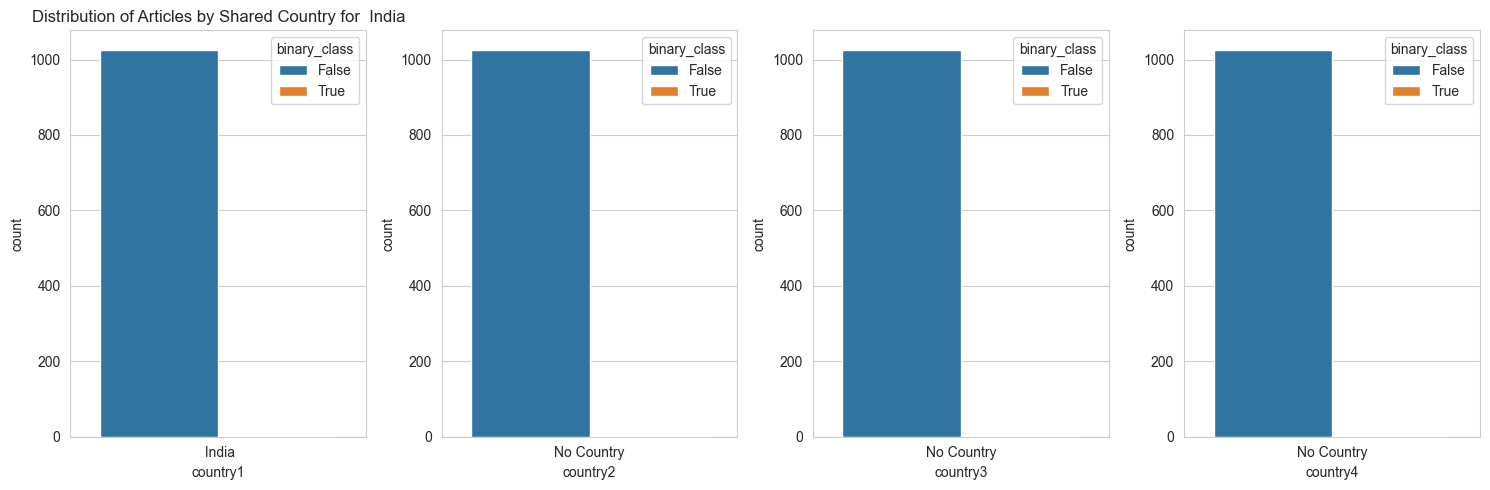

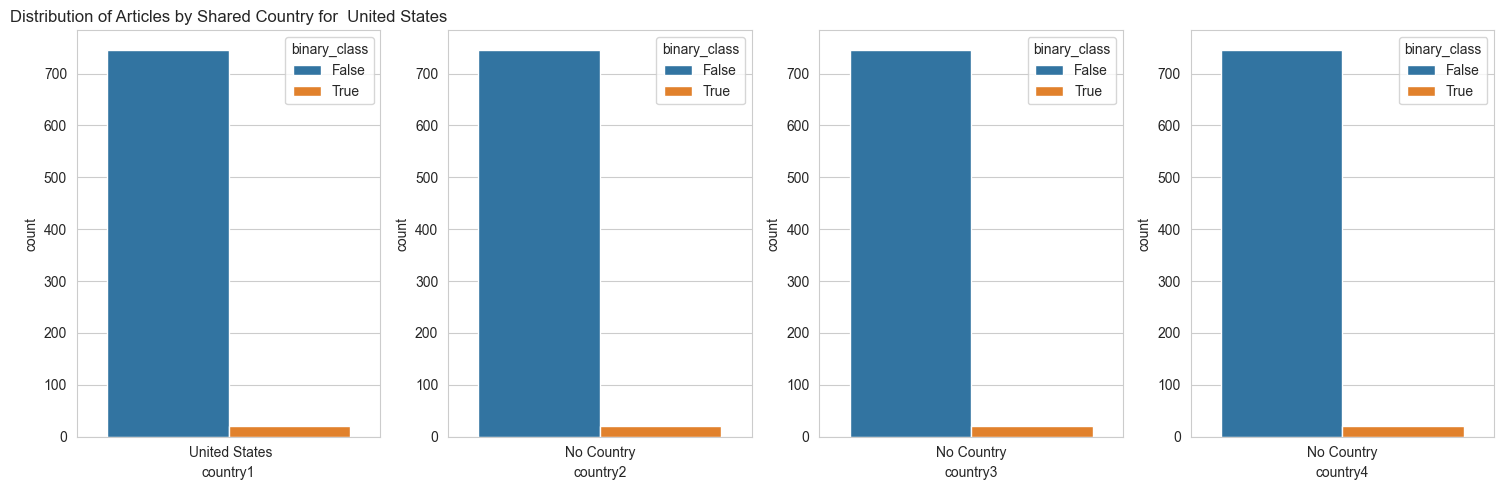

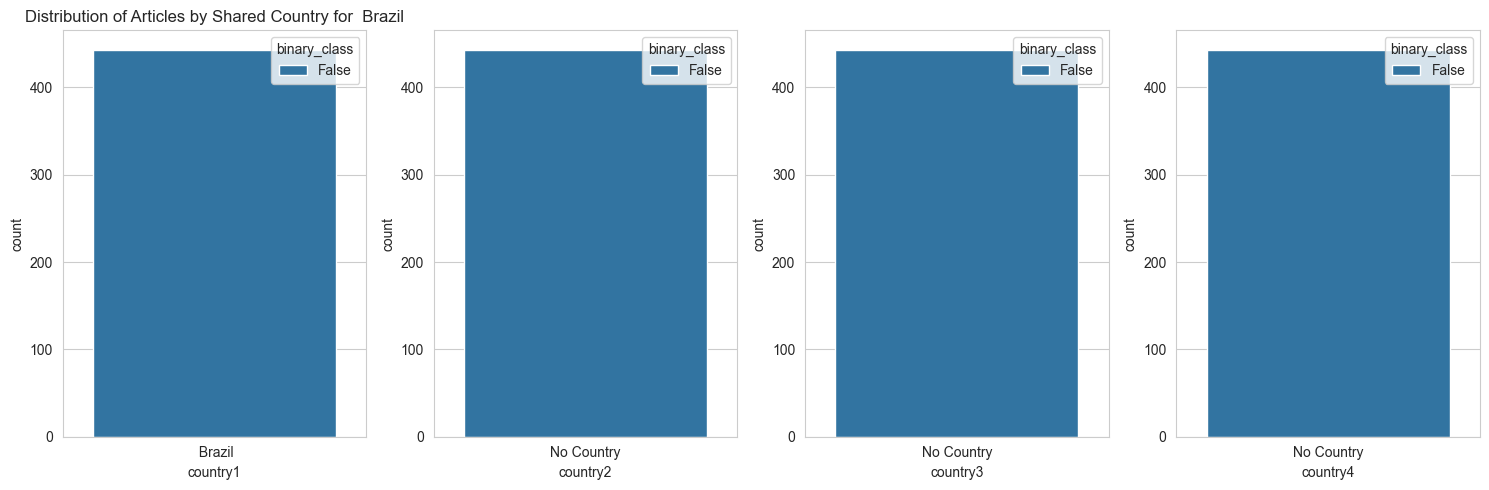

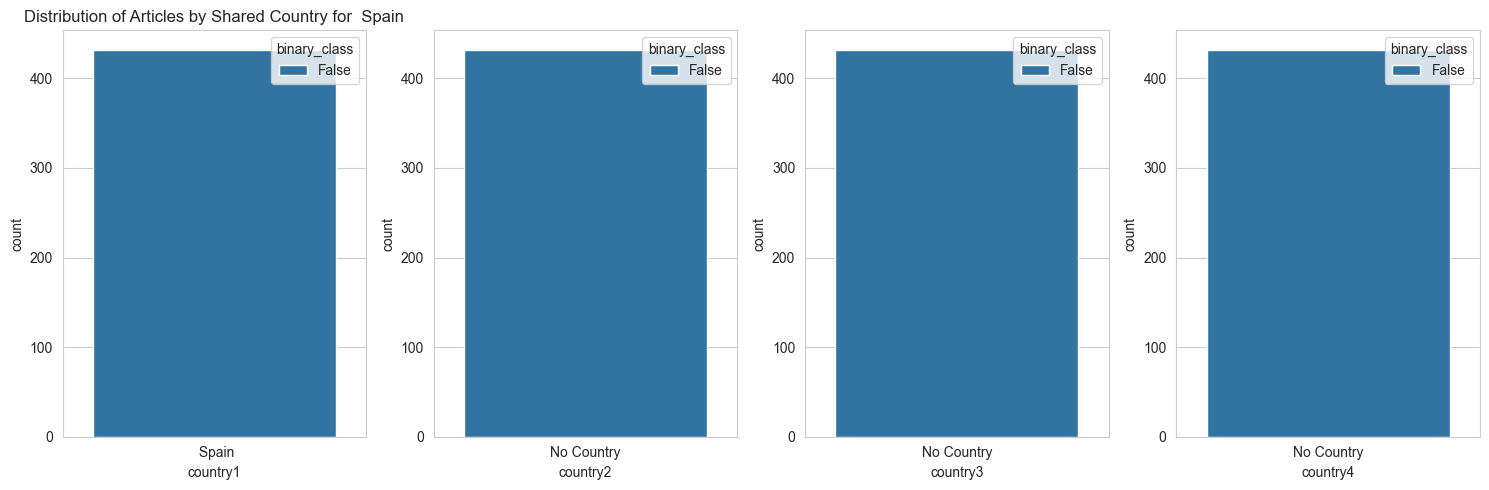

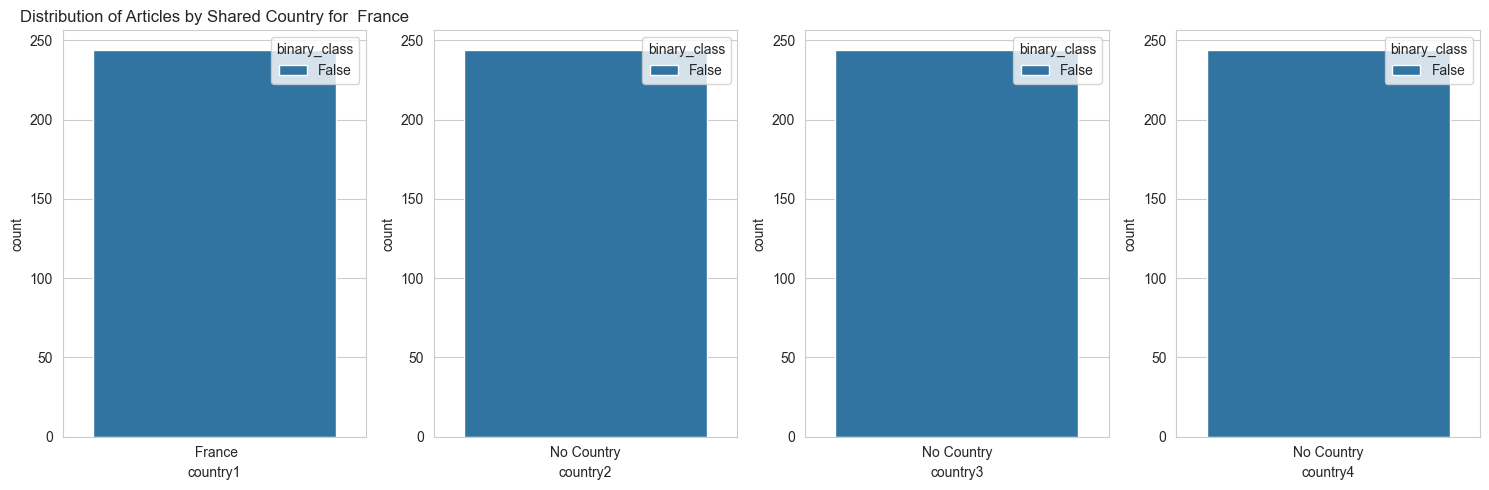

In [11]:
# Let's first get the top 50 countries by "country" value count.
top_5_countries = data_cleaned['country'].value_counts().head(5).index.tolist()

# Then, for each of these countries, we'll identify the distribution of country1, country2, country3, country4,
# along with the class of fake news "binary class".

# We'll create a dictionary to hold the data
country_sharing_distribution = {}

# Loop through each of the top 50 countries
for country in top_5_countries:
    # Filter the dataset for the current country
    country_data = data_cleaned[data_cleaned['country'] == country]
    # Filtering the data to exclude entries where all four country columns have the value "No Country"
    country_filtered_data = country_data[
        (country_data['country1'] != 'No Country') |
        (country_data['country2'] != 'No Country') |
        (country_data['country3'] != 'No Country') |
        (country_data['country4'] != 'No Country')
    ]

    # Distribution of articles by language
    fig, ax = plt.subplots(1, 4, figsize=(15, 5))    
    title = "Distribution of Articles by Shared Country for {}".format(country)
    ax[0].set_title(title)
    sns.countplot(ax=ax[0],data=country_filtered_data, x='country1', order=country_filtered_data['country1'].value_counts()[0:5].index, hue='binary_class')

    #ax[1].set_title(title)
    sns.countplot(ax=ax[1],data=country_filtered_data, x='country2', order=country_filtered_data['country2'].value_counts()[0:5].index, hue='binary_class')

    #ax[2].set_title(title)
    sns.countplot(ax=ax[2], data=country_filtered_data, x='country3', order=country_filtered_data['country3'].value_counts()[0:5].index, hue='binary_class')

    #ax[3].set_title(title)
    sns.countplot(ax=ax[3],data=country_filtered_data, x='country4', order=country_filtered_data['country4'].value_counts()[0:5].index, hue='binary_class')
    plt.tight_layout()
    plt.show()
    

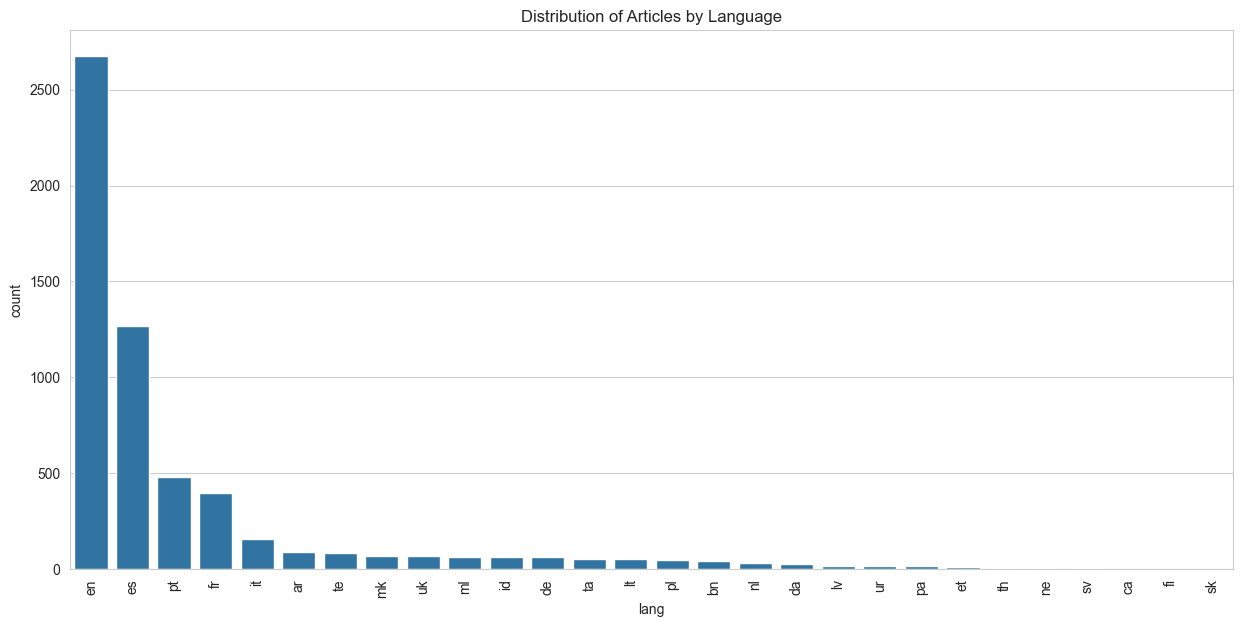

In [12]:
# Distribution of articles by language
plt.figure(figsize=(15, 7))
sns.countplot(data=data_cleaned, x='lang', order=data_cleaned['lang'].value_counts().index)
plt.title('Distribution of Articles by Language')
plt.xticks(rotation=90)
plt.show()

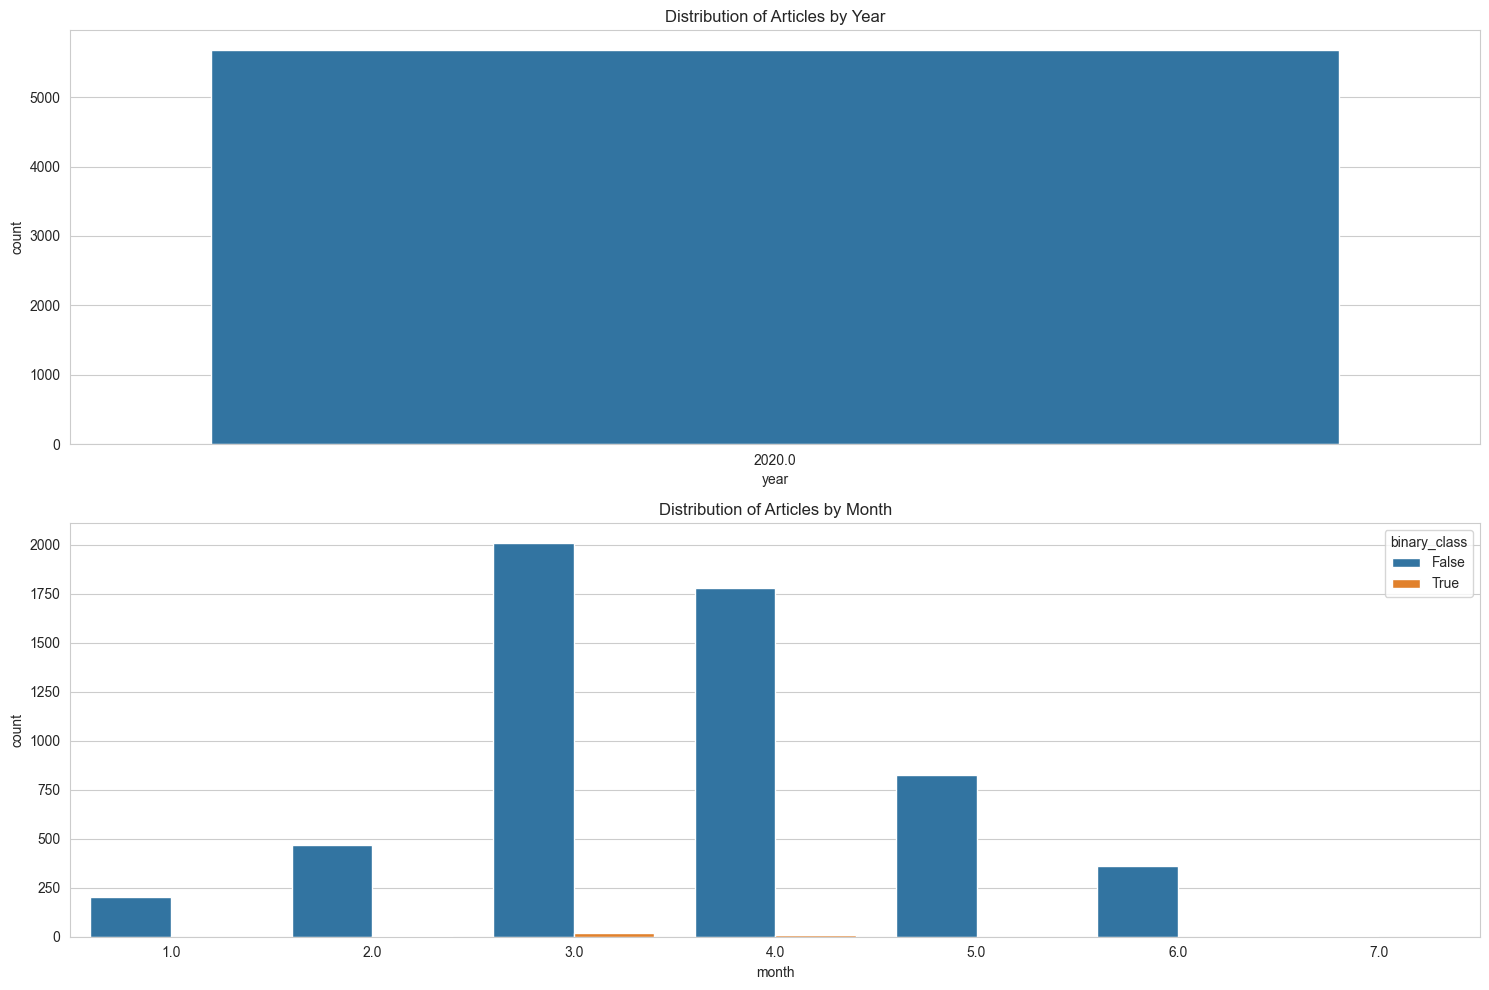

In [13]:
# Temporal distribution of articles by year and month
fig, ax = plt.subplots(2, 1, figsize=(15, 10))
sns.countplot(data=data_cleaned, x='year', ax=ax[0])
ax[0].set_title('Distribution of Articles by Year')
sns.countplot(data=data_cleaned, x='month', ax=ax[1],hue='binary_class')
ax[1].set_title('Distribution of Articles by Month')
plt.tight_layout()
plt.show()

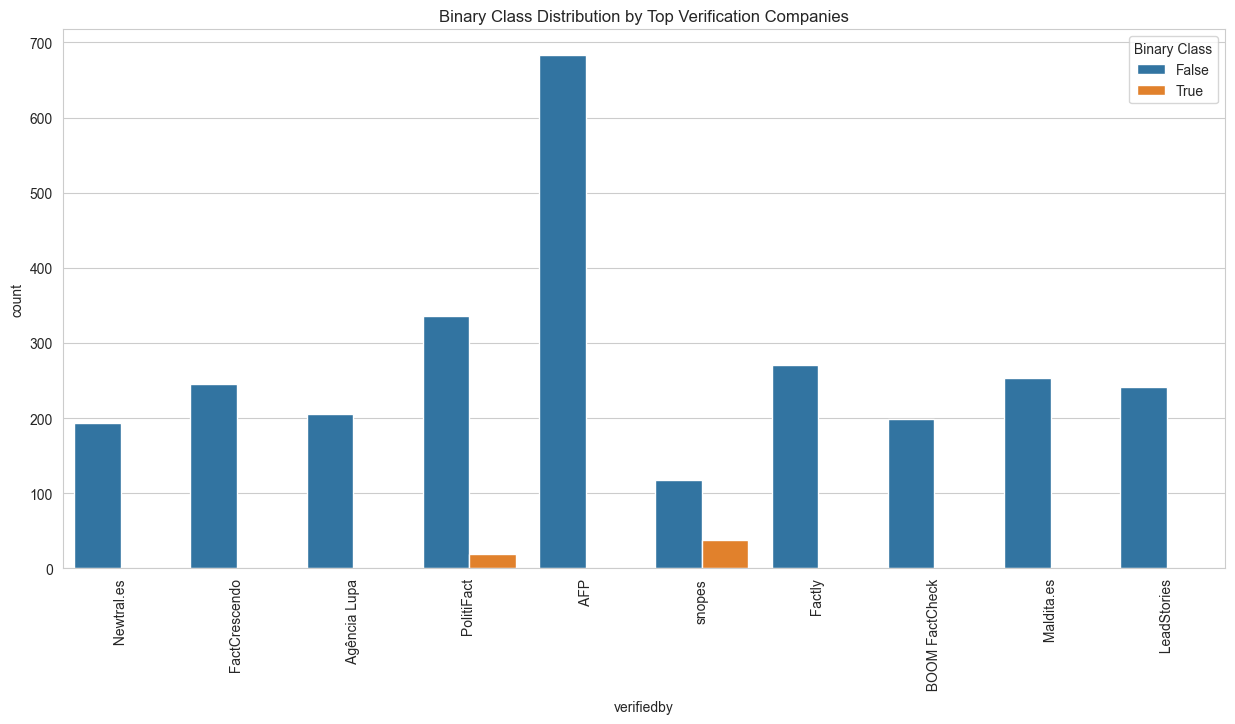

In [14]:
# Let's also look at the distribution of the binary class within some of the categorical features
# This will help us to build hypotheses about the relationship between these features and the binary class

# Binary class distribution by top verification companies
top_verifiedby = data_cleaned['verifiedby'].value_counts().index[:10]
plt.figure(figsize=(15, 7))
sns.countplot(data=data_cleaned[data_cleaned['verifiedby'].isin(top_verifiedby)], x='verifiedby', hue='binary_class')
plt.title('Binary Class Distribution by Top Verification Companies')
plt.xticks(rotation=90)
plt.legend(title='Binary Class')
plt.show()

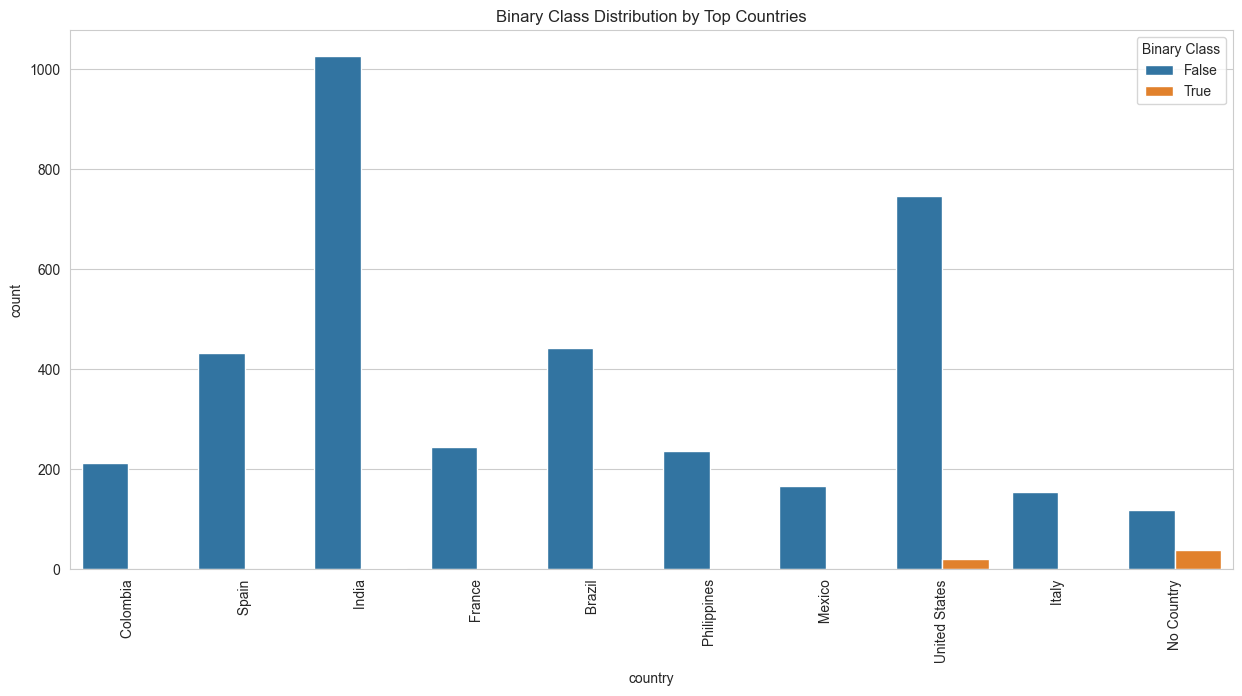

In [15]:
# Binary class distribution by top countries
top_countries = data_binary['country'].value_counts().index[:10]
plt.figure(figsize=(15, 7))
sns.countplot(data=data_cleaned[data_cleaned['country'].isin(top_countries)], x='country', hue='binary_class')
plt.title('Binary Class Distribution by Top Countries')
plt.xticks(rotation=90)
plt.legend(title='Binary Class')
plt.show()

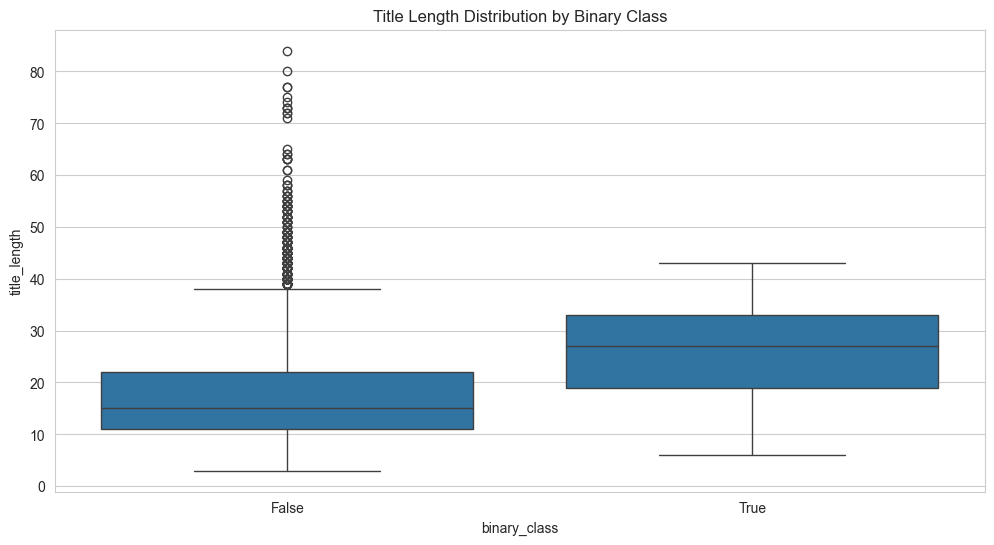

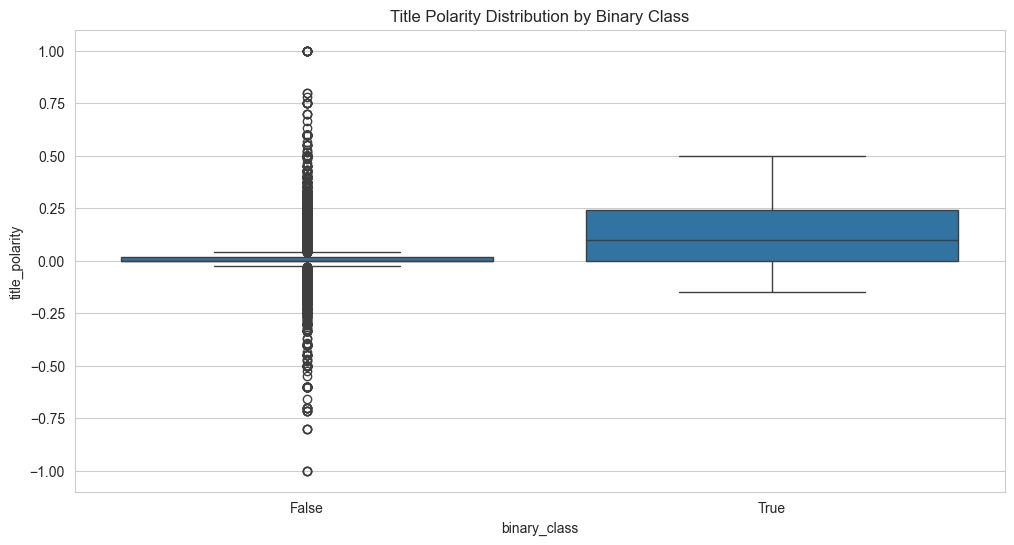

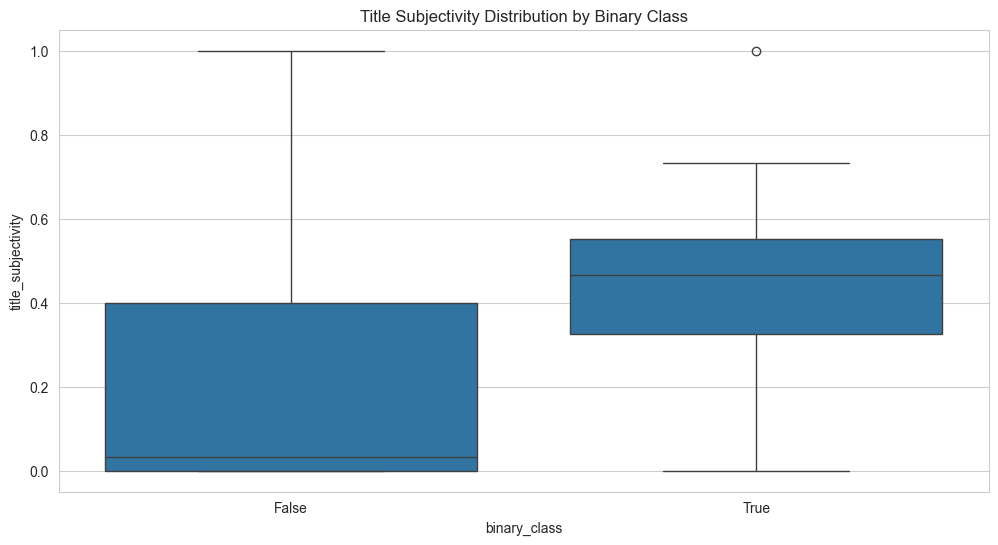

In [16]:
# Sentiment Analysis
from textblob import TextBlob

data_cleaned['title_length'] = data_cleaned['title'].apply(lambda x: len(x.split()))

# Add features for the polarity and subjectivity of the title
data_cleaned['title_polarity'] = data_cleaned['title'].apply(lambda x: TextBlob(x).sentiment.polarity)
data_cleaned['title_subjectivity'] = data_cleaned['title'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

# Now, let's visualize the newly created features in relation to the binary class
plt.figure(figsize=(12, 6))
sns.boxplot(x='binary_class', y='title_length', data=data_cleaned)
plt.title('Title Length Distribution by Binary Class')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='binary_class', y='title_polarity', data=data_cleaned)
plt.title('Title Polarity Distribution by Binary Class')
plt.show()

plt.figure(figsize=(12, 6))
sns.boxplot(x='binary_class', y='title_subjectivity', data=data_cleaned)
plt.title('Title Subjectivity Distribution by Binary Class')
plt.show()

- This suggests that the length of a news title could be a useful feature in a predictive model, as there is a clear distinction in the length distribution between 'True' and 'False' classes.
- The polarity feature seems to have some predictive power, as there is a noticeable difference in distribution between the two classes, despite some overlap.
- title subjectivity seems to show a different distribution between the two classes and could therefore be considered a predictive feature. 

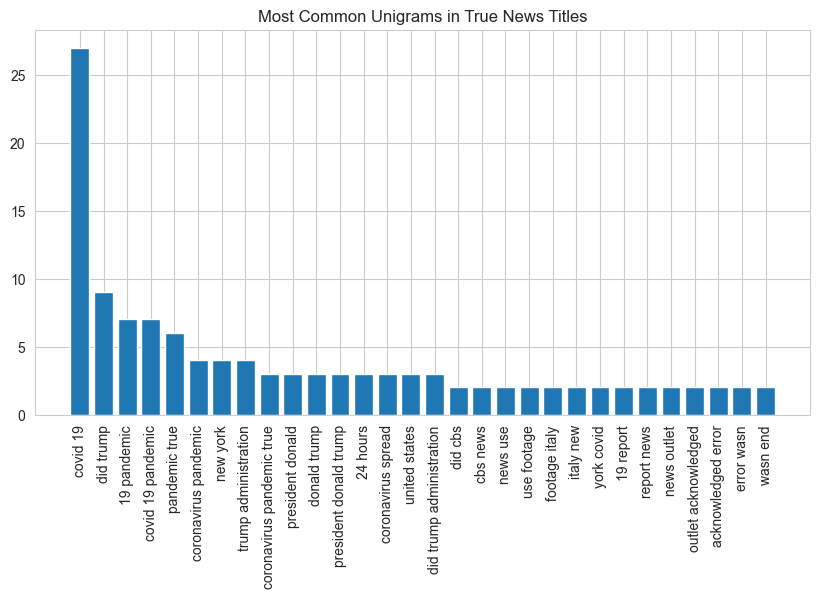

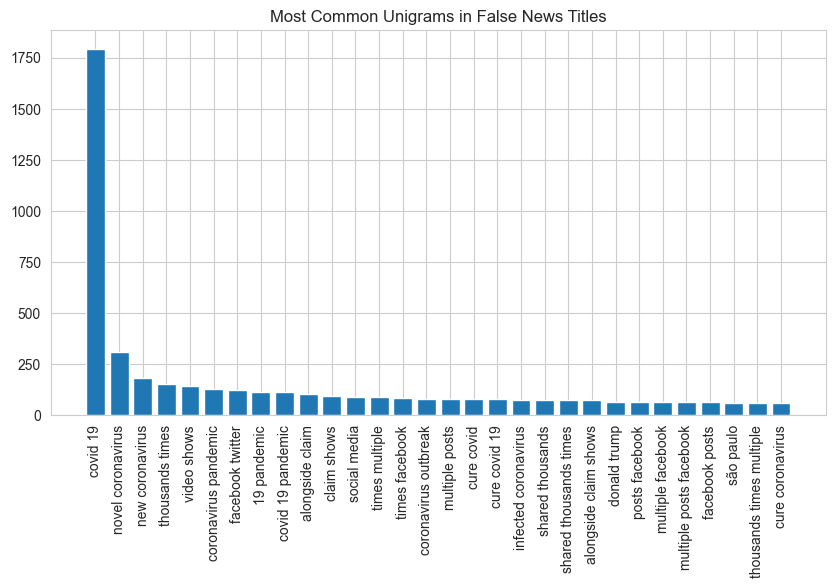

In [17]:
from sklearn.feature_extraction.text import CountVectorizer

# We will use CountVectorizer to analyze unigrams without stopwords

# Function to plot most common unigrams
def plot_most_common_unigrams(data, title, n=30):
    # Initialize the CountVectorizer
    count_vect = CountVectorizer(stop_words='english', ngram_range = (2, 3))
    # Fit and transform the data
    word_count = count_vect.fit_transform(data)
    # Sum up the counts of each vocabulary word
    sum_words = word_count.sum(axis=0)
    # Map from indices to words
    words_freq = [(word, sum_words[0, idx]) for word, idx in count_vect.vocabulary_.items()]
    # Sort the words by frequency
    sorted_words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)[:n]
    # Create a bar plot for the most common words
    words, counts = zip(*sorted_words_freq)
    plt.figure(figsize=(10, 5))
    plt.bar(words, counts)
    plt.title(title)
    plt.xticks(rotation=90)
    plt.show()

# Extract titles for 'True' and 'False' classes
titles_true = data_cleaned[data_cleaned['binary_class'] == 'True']['title']
titles_false = data_cleaned[data_cleaned['binary_class'] == 'False']['title']

# Plot the most common unigrams in titles for 'True' class
plot_most_common_unigrams(titles_true, 'Most Common Unigrams in True News Titles')

# Plot the most common unigrams in titles for 'False' class
plot_most_common_unigrams(titles_false, 'Most Common Unigrams in False News Titles')


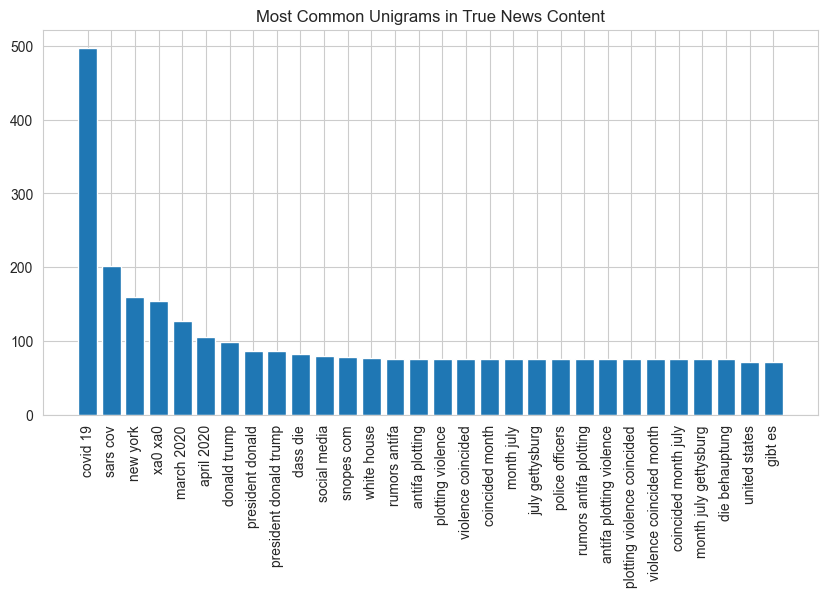

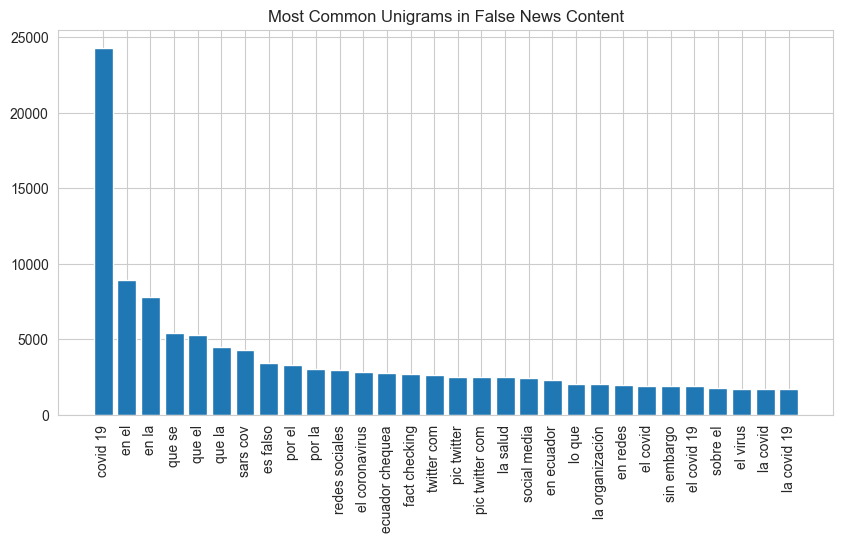

In [18]:
# Extract titles for 'True' and 'False' classes
titles_true = data_cleaned[data_cleaned['binary_class'] == 'True']['content_text']
titles_false = data_cleaned[data_cleaned['binary_class'] == 'False']['content_text']

# Plot the most common unigrams in titles for 'True' class
plot_most_common_unigrams(titles_true, 'Most Common Unigrams in True News Content')

# Plot the most common unigrams in titles for 'False' class
plot_most_common_unigrams(titles_false, 'Most Common Unigrams in False News Content')


In [19]:
def lexical_diversity(text):
    tokens = text.split()
    return len(set(tokens)) / len(tokens) if tokens else 0
    
data_cleaned['lexical_diversity'] = data_cleaned['content_text'].apply(lexical_diversity)

In [20]:
from urllib.parse import urlparse

# Define a function to extract domain from URL
def extract_domain(url):
    parsed_uri = urlparse(url)
    # Extract the domain name (base URL)
    domain = '{uri.scheme}://{uri.netloc}/'.format(uri=parsed_uri)
    return domain

# Apply the function to your dataset
data_cleaned['source_domain'] = data_cleaned['article_source'].apply(extract_domain)

Identifying credible domains based on the source_domain and its association with the binary class indicating fake news involves a data-driven approach. You'll be analyzing the patterns in the source_domain relative to the binary_class column, which indicates whether news is fake (0 or 1, assuming 0 is for credible and 1 is for fake news).

Here's a conceptual outline of the steps you'd take:

- Calculate Ratios:
  Calculate the ratio of fake to credible news for each domain.



In [29]:

# Group by source_domain and calculate the number of fake and credible news
domain_summary = data_cleaned.groupby('source_domain')['binary_class'].agg([("fake_count", lambda x: (x=='False').sum()), ("credible_count", lambda x: (x=='True').sum())])

# Calculate the ratio of fake news
domain_summary['fake_ratio'] = domain_summary['fake_count'] / (domain_summary['fake_count'] + domain_summary['credible_count'])

# You may decide on a threshold to determine credibility; this is arbitrary and should be based on your analysis
threshold = 0.98
domain_summary['is_credible'] = domain_summary['fake_ratio'] > threshold

In [30]:
domain_summary

,fake_count,credible_count,fake_ratio,is_credible
source_domain,,,,
http://aosfatos.org/,1,0,1.000000,True
http://boliviaverifica.bo/,5,0,1.000000,True
http://factuel.afp.com/,3,0,1.000000,True
http://mythdetector.ge/,11,0,1.000000,True
http://newsmobile.in/,9,0,1.000000,True
...,...,...,...,...
https://www.snopes.com/,118,38,0.756410,False
https://www.thejournal.ie/,38,0,1.000000,True
https://www.thequint.com/,87,1,0.988636,True


In [31]:
domain_summary.sort_values(by='fake_ratio',ascending=False, inplace=True)

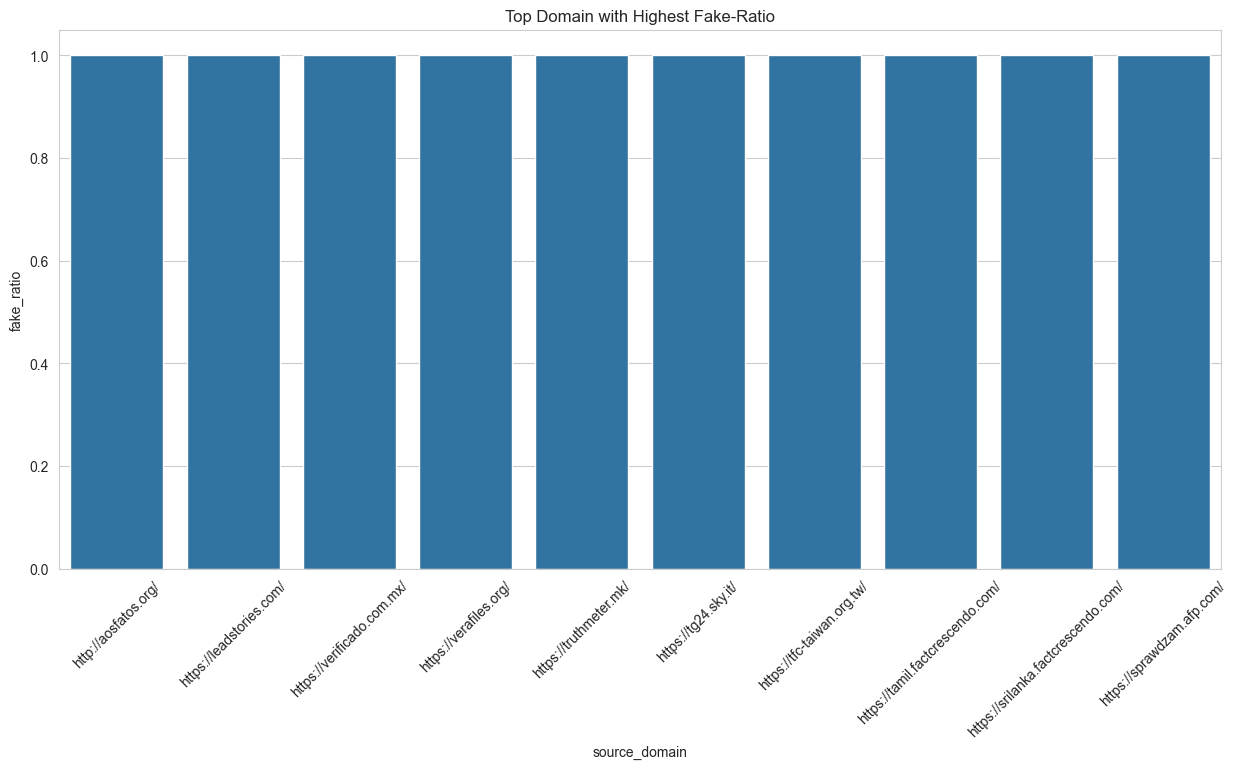

In [32]:
domain_summary['source_domain'] = domain_summary.index
plt.figure(figsize=(15, 7))
sns.barplot(data=domain_summary[0:10], x='source_domain',y='fake_ratio')
plt.title('Top Domain with Highest Fake-Ratio')
plt.xticks(rotation=45)
plt.show()

In [33]:
# Map the domain credibility back onto the original dataset
domain_credibility = domain_summary['is_credible'].to_dict()
data_cleaned['domain_is_credible'] = data_cleaned['source_domain'].map(domain_credibility)

In [34]:
domain_fake_ratio = domain_summary['fake_ratio'].to_dict()
data_cleaned['domain_fake_ratio'] = data_cleaned['source_domain'].map(domain_fake_ratio)

In [35]:
data_cleaned

,verifiedby,country,class,title,published_date,country1,country2,country3,country4,article_source,...,binary_class,year,month,title_length,title_polarity,title_subjectivity,lexical_diversity,source_domain,domain_is_credible,domain_fake_ratio
0,La Silla Vacía,Colombia,FALSE,The coronavirus is an amplified bacteria rela...,2020-06-17,Colombia,No Country,No Country,No Country,https://lasillavacia.com/detector-video-falso-...,...,False,2020.0,6.0,9,0.00,0.400000,0.506427,https://lasillavacia.com/,True,1.0
1,Newtral.es,Spain,FALSE,A law allows people to go for a run during th...,2020-04-09,Spain,No Country,No Country,No Country,https://www.newtral.es/la-broma-de-que-a-los-r...,...,False,2020.0,4.0,16,0.00,0.000000,0.621253,https://www.newtral.es/,True,1.0
2,FactCrescendo,India,False,Chinese converting to Islam after realizing t...,2020-02-20,India,No Country,No Country,No Country,https://english.factcrescendo.com/2020/02/20/c...,...,False,2020.0,2.0,16,0.00,0.000000,0.544073,https://english.factcrescendo.com/,True,1.0
3,France 24 Observers,France,False,Bat market and bat meat are being sold in Wuhan.,2020-01-27,France,No Country,No Country,No Country,https://observers.france24.com/fr/20200130-int...,...,False,2020.0,1.0,10,0.00,0.000000,0.633663,https://observers.france24.com/,True,1.0
4,Agência Lupa,Brazil,False,You can self-diagnose COVID-19 by holding you...,2020-03-16,Brazil,No Country,No Country,No Country,https://piaui.folha.uol.com.br/lupa/2020/03/16...,...,False,2020.0,3.0,24,0.00,0.333333,0.541507,https://piaui.folha.uol.com.br/,True,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6894,AFP,Malaysia,FALSE,A video has been viewed thousands of times on...,2020-04-09,Malaysia,No Country,No Country,No Country,https://factcheck.afp.com/video-shows-safety-d...,...,False,2020.0,4.0,44,-0.10,0.100000,0.584786,https://factcheck.afp.com/,True,1.0
6895,Convoca.pe,Peru,False,An audio shared on WhatsApp indicates that th...,2020-03-19,Peru,No Country,No Country,No Country,https://convoca.pe/convoca-radio/coronavirus-d...,...,False,2020.0,3.0,16,0.00,0.100000,0.715328,https://convoca.pe/,True,1.0
6896,Agência Lupa,Brazil,FALSE,"While the world was worried with COVID-19, Ch...",2020-06-18,Brazil,No Country,No Country,No Country,https://piaui.folha.uol.com.br/lupa/2020/06/18...,...,False,2020.0,6.0,22,0.25,0.312500,0.660465,https://piaui.folha.uol.com.br/,True,1.0
6899,LeadStories,United States,FALSE,Doctors encouraged by hospitals and AMA to ov...,2020-04-25,United States,No Country,No Country,No Country,https://leadstories.com/hoax-alert/2020/05/fac...,...,False,2020.0,4.0,10,0.00,0.000000,0.500000,https://leadstories.com/,True,1.0


In [36]:
data_cleaned.to_excel('../data/clean_data.xlsx',index=False)